Part 3 of TP 1 of IFT-6135

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
import os
import pickle
import csv
import time
import math
import imageio
from torch.autograd import Variable
import copy

    100% |████████████████████████████████| 753.6MB 53.2MB/s 
    100% |████████████████████████████████| 2.0MB 1.9MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


Load images, .zip file is loaded on google drive. They are in the same format as provided on Kaggle.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# path to store results/plots/models
added_path = 'drive/My Drive/dev_1_6135/'

train_path = 'trainset/'
test_path = 'testset/'

# path of train and test set
!unzip  'drive/My Drive/dev_1_6135/ift6135h19/testset'

!unzip  'drive/My Drive/dev_1_6135/ift6135h19/trainset'


For some reason, we are getting  AttributeError: module 'PIL.Image' has no attribute 'register_extensions
if we don't install pillow version 4.1.1

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.8MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


Load the data, set the data augmentation, and some hyperparameters

In [0]:
img_size = 64
n_channels = 3

# batch_size 64 is fine for big models
batch_size = 64
# 512 bach size gives CUDA run out of memory
batch_size_eval = 256


# If a GPU is available, use it
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False

    
class MyImageFolder(datasets.ImageFolder):
    """ Taken from 
    https://discuss.pytorch.org/t/torch-utils-data-dataloader
    -get-input-class-and-image-name/1658
    
    return (image, label), image path 
    """
    def __getitem__(self, index):
        return super(MyImageFolder, self).__getitem__(index), self.imgs[index]   
    

# Augment data because 20k images is not enough
# and lead to significant overfitting !
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),   
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data = MyImageFolder(train_path, transform_train)
valid_data = MyImageFolder(train_path, transform_test)
test_data = MyImageFolder(test_path, transform_test)

num_classes = len(train_data.classes)
set_classes = train_data.classes
print('classes = ', set_classes)


# 90%-10% split seems fine for our data set
n_train_images = int(len(train_data) * 0.90)
n_valid_images = int(len(train_data) - n_train_images)
n_test_images = int(len(test_data))

print('n_train_images =', n_train_images, 'n_valid_images =', n_valid_images,
      'n_test_images =', n_test_images)

  
indices = list(range(len(train_data)))
random.shuffle(indices)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[:n_train_images]),
    pin_memory=use_cuda
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[n_train_images:]),
    pin_memory=use_cuda,
)


test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    pin_memory=use_cuda,
    shuffle=False
)

classes =  ['Cat', 'Dog']
n_train_images = 17998 n_valid_images = 2000 n_test_images = 4999


   Cat     Dog     Dog     Cat     Cat     Cat     Cat 


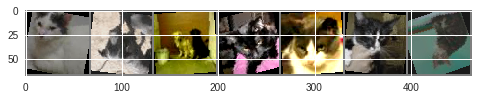

In [0]:

def print_some_image(loader, n_images):
    # visualize and understand the data
    # also used to check if our labels for test set makes sense
    # get some random training images
    dataiter = iter(train_loader)
    (images, labels), img_path = dataiter.next()

    # show images
    imshow(utils.make_grid(images[:n_images, :, :, :]))
    # print labels
    print(' '.join(' %5s ' % set_classes[labels[j]] for j in range(n_images)))

def print_one_image(img, label):
    plt.figure()
    plt.title(label)
    imshow(img)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
print_some_image(train_loader, 7)


VGG - type Convolutional Neural Network

In [0]:
class VGGNet(nn.Module):
    """ """
    
    def __init__(self):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        # w_out = w_in + 3 - kernel (for padding=1, stride=1, dilation=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # conv block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        # fully connected layers
        self.fc1 = nn.Linear(4096, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        # x is [batch_size, channels, heigth, width] = [bs, 3, 64, 64]
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.max_pool2d(x, 2) 
        
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.max_pool2d(x, 2) 
        
        x = F.elu(self.conv5(x))
        x = F.elu(self.conv6(x))
        x = F.max_pool2d(x, 2)
        
        x = F.elu(self.conv7(x))
        x = F.elu(self.conv8(x))
        x = F.max_pool2d(x, 2) 
        
        x = F.elu(self.conv9(x))
        x = F.elu(self.conv10(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        

ResNet Implementation

In [0]:

class Block(nn.Module):
  
    def __init__(self, n_c_in, n_c_out, activ='relu'):
        super().__init__()

        if n_c_in * 2 == n_c_out:
          self.stride = 2
          # Double the dimensionality of X
          self.expand_x = nn.Conv2d(n_c_in, n_c_out, kernel_size=1, 
                                    stride=self.stride, padding=0, bias=False)
        elif n_c_in == n_c_out:
          self.stride = 1
          self.expand_x = None
        else:
          self.stride = -1
          raise ValueError('n_c_in = %s; n_c_out = %s : Invalid !' 
                           % (str(n_c_in),  str(n_c_out)))
        
        if activ.lower() == 'relu':
          self.activ =  nn.ReLU()
        elif activ.lower() == 'elu':
          self.activ =  nn.ELU()
        elif activ.lower() == 'leakyrelu':
          self.activ =  nn.LeakyReLU()
        else:
          raise ValueError('Invalid activation function: ' + self.activ)
          
        # "if the feature map size is halved, the number of filters 
        # is doubled so as to preserve the time complexity per layer."
        self.conv1 = nn.Conv2d(n_c_in, n_c_out, kernel_size=3, 
                               stride=self.stride, padding=1, bias=False)
        
        self.conv2 = nn.Conv2d(n_c_out, n_c_out, kernel_size=3, 
                               padding=1, bias=False)
        
        self.bias = nn.ParameterList([nn.Parameter(torch.zeros([1]))] * 4)
        self.multiplier = nn.Parameter(torch.ones([1]))
           
    def res(self, x):
        x = x + self.bias[0]
        x = self.activ(self.conv1(x) + self.bias[1])
        x = x + self.bias[2]
        x = self.multiplier * self.conv2(x) + self.bias[3]
        return x
           
    def forward(self, x):   
        if self.stride == 2:
          return self.activ(self.res(x) + self.expand_x(x))
        else:
          return self.activ(self.res(x) + x)                     
      

class ResNet(nn.Module):
    """ """
    
    def __init__(self, n_c_first, n_classes, activ='relu', fixup_init=True,
                use_max_pooling=True):
        super().__init__()
        
        # First convlayer  before residual branches     
        self.conv1 = nn.Conv2d(n_channels, n_c_first, kernel_size=7, 
                               stride=2, padding=3, bias=False)
        
        self.str_activ = activ.lower()
        if self.str_activ == 'relu':
          self.activ = nn.ReLU()
        elif  self.str_activ == 'elu':
          self.activ = nn.ELU()
        elif  self.str_activ == 'leakyrelu':
          self.activ = nn.LeakyReLU()
        else:
          raise ValueError('Invalid activation function: ' +  self.str_activ)                 
        
        # res_18 =
        #n_blocks = [2, 2, 2, 2]
          
        # res_34 =
        n_blocks = [3 , 4 , 6 , 3] 
        
        
        channels = [n_c_first, n_c_first, n_c_first * 2, n_c_first * 4, n_c_first * 8]
        
        self.n_res_branches = sum(n_blocks)
        
        print('n_res_branches =', self.n_res_branches, '; n_blocks =', n_blocks)
        print('channels =', channels)
        
        # all layers, which are themselves constitued of blocks
        self.l1 = self.make_blocks(n_blocks[0], channels[0], channels[1])       
        self.l2 = self.make_blocks(n_blocks[1], channels[1], channels[2])
        self.l3 = self.make_blocks(n_blocks[2], channels[2], channels[3])
        self.l4 = self.make_blocks(n_blocks[3], channels[3], channels[4])
        
        
        self.nchannels_last = channels[-1]
          
        self.fc = nn.Linear(self.nchannels_last, n_classes)
        
        if fixup_init:
          self.weight_init()
        
    def make_blocks(self, n_blocks, n_c_in, n_c_out):
      self.blocks = []
    
      # first block, we go from n_c_in number of channel to 
      # n_c_out number of channel 
      self.blocks.append(Block(n_c_in, n_c_out, activ=self.str_activ))

      for i in range(1, n_blocks):
          self.blocks.append(Block(n_c_out, n_c_out, activ=self.str_activ))

      return nn.Sequential(*self.blocks)
    
    def weight_init(self):
      """ Fixup initialization, (Zhang et al. 2019)"""
      
      # First conv before layers, use He. init 
      nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', 
                              nonlinearity='relu')
      
      # set all fully connected layer's biases + weights to 0
      self.fc.weight.data.zero_()
      self.fc.bias.data.zero_()
      
      for layer in [self.l1, self.l2, self.l3, self.l4]:          
        for b in layer:
                 
          # He init
          nn.init.kaiming_normal_(b.conv1.weight, mode='fan_out', 
                                  nonlinearity='relu')
          # scale by L**(-1 / (2m - 2)); here m=2
          b.conv1.weight.data /= self.n_res_branches ** (0.5)
          
          b.conv2.weight.data.zero_()
          
          # He init
          if isinstance(b.expand_x, nn.Conv2d):
            nn.init.kaiming_normal_(b.expand_x.weight, mode='fan_out', 
                                    nonlinearity='relu')
            
          
              
    def forward(self, x):
        
        x = self.activ(self.conv1(x))        
        
        if use_max_pooling:
          x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
               
        # Blocks
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        
        # Global average pooling
        x = F.avg_pool2d(x, kernel_size=x.size()[2:]).view(x.size()[0],-1)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.fc(x)
        
        return x
        

In [0]:
#####################################################
n_epochs = 150


def count_parameters(model):
  return sum(p.numel() for p in model.parameters())

def train(model, loss_fn, epoch):
  
    model.train()

    time_now = time.clock()
    
    t_loss, correct, t_size = 0, 0, 0
      
    for batch_idx, ((inputs, target), img_path) in enumerate(train_loader):

        inputs, target = inputs.to(device), target.to(device)
        
        model.zero_grad()
        
        output = model(inputs)
        loss = loss_fn(output, target)
        t_size += len(inputs)
        # sum up batch loss
        t_loss += loss.item()
        pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0 and batch_idx > 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)] Time per epoch: {:.2f}s; '
                  'Avg_Loss: {:.4f}; Accuracy: {}/{} ({:.0f}%)'
                  ''.format(epoch + 1, t_size, n_train_images, 100. * t_size / n_train_images,
                            n_train_images / (10 * batch_size) * (time.clock() - time_now), 
                             t_loss * batch_size / t_size, correct, t_size, 100. * correct / t_size),
                  end='')
            time_now = time.clock()
            
    t_loss *=  batch_size / t_size
    accuracy = correct / t_size
    return t_loss, accuracy


def valid(model, loss_fn):
  
    model.eval()

    t_loss, correct, t_size = 0, 0, 0

    with torch.no_grad():
        for ((inputs, target), img_path) in valid_loader:
          
            inputs, target = inputs.to(device), target.to(device)

            output = model(inputs)

            t_size += len(inputs)
            # sum up batch loss
            t_loss += loss_fn(output, target).item() 
            
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    t_loss /= t_size
    accuracy = correct / t_size
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          ''.format(t_loss, correct, t_size, 100. * accuracy))

    return t_loss, accuracy

  
# Hyperparameters exclusively for ResNet model
use_fix_up_init = False
use_max_pooling = True
activ = 'elu'
############


### Decide to run either VGG or ResNet model
do_vggnet_model = True

if do_vggnet_model:
  model = VGGNet().to(device)
  str_model = 'vgg_net
else:
  model = ResNet(64, num_classes, activ, use_fix_up_init, 
                 use_max_pooling).to(device)
  str_model = 'res_net'


n_parameters = count_parameters(model)
print('n_parameters = ', n_parameters)
print('Using Fixup init = %s; Max_pooling = %s; activation = %s'
     % (str(use_fix_up_init),  str(use_max_pooling), activ))

# Loss function
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

# Learning rate
lr = 0.1
# Normal SGD with 0 momentum
optimizer = optim.SGD(model.parameters(), lr)

# Decay the learning rate by factor of gamma every step_size # of epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)


# where we save our learning curves
savedir = added_path + 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

results = {'name': 'basic', 'lr': lr, 'loss_train': [], 'loss_valid': [], 
           'accuracy_train': [],  'accuracy_valid': [], 'activ': activ,
           'fixup_init': str(use_fix_up_init), 'img_size': img_size,
           'max_pooling': str(use_max_pooling), 'n_parameters': n_parameters}

savefile = os.path.join(savedir, results['name'] + str_model  + '_'
                        + results['activ'] + '_' + 'fixup=' + results['fixup_init'] 
                        + '_' +  str(img_size) + '_pool=' + results['max_pooling']  + '.pkl')

for ep in range(n_epochs):
    scheduler.step()
    loss_train, acc_train = train(model, loss_fn, ep)
    loss_valid, acc_valid = valid(model, test_loss_fn)

    # save results every epoch
    results['loss_train'].append(loss_train)
    results['accuracy_train'].append(acc_train)
    results['loss_valid'].append(loss_valid)
    results['accuracy_valid'].append(acc_valid)
    
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)
        
    if ep % 10 == 0 and ep > 5:
      # Save the model !
      torch.save(model.state_dict(), added_path + 'model' + str(ep) + str_model + '.pth')


#########################################
# At the end, find most likely labels of test data and save it to file

myData = [[]]

def test(model):
  
    model.eval()
    
    with torch.no_grad():
        for batch_idx, ((inputs, target), img_path) in enumerate(test_loader):
          
            print('\rTesting (%s / %s) %.2f%%)' % (batch_size_eval * batch_idx, 
                                                 len(test_data), 
                                                 100. * batch_size_eval * batch_idx / len(test_data)), 
                  end='')
          
            inputs, target = inputs.to(device), target.to(device)

            output = model(inputs)
            
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
                  
            for i, p in enumerate(pred):
                idx = int(batch_size_eval * batch_idx + i)
  
                img_number = ''.join([n for n in img_path[0][i] if n.isdigit()])
                
                myData.append([img_number, set_classes[p.item()]])
                
                # print some imgs to make sure we didn't mess up our test labeling
                if idx % 900 == 0:
                    print_one_image(inputs[i].view(n_channels, img_size, img_size).cpu(), set_classes[p.item()])
                    
                
                 
test(model)

myData = myData[1:]

# sort from img 0 to 4999
myData.sort(key=lambda x: int(x[0]))

myData = [['id', 'label']] + myData

print('\nlen(myData) = ', len(myData))

csv.register_dialect('myDialect', delimiter=',', quoting=csv.QUOTE_NONE)

myFile = open(added_path + 'results_cnn.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile, dialect='myDialect')
   writer.writerows(myData)
  
print('Data is saved !')

# Save the model !
torch.save(model.state_dict(), added_path + 'model.pth')
print('Model is saved ! All done !')



Visualization of our results with gradient ascent, to find the image that maximizes
the score of a given class

Cat : loss = 0.5800
Cat : loss = 12.6103
Cat : loss = 11.6930
Cat : loss = 14.1856
Cat : loss = 13.1947
Cat : loss = 15.9162
Cat : loss = 12.7297
Cat : loss = 16.4451
Cat : loss = 12.6838
Cat : loss = 16.3898
Dog : loss = -0.5855
Dog : loss = 9.2593
Dog : loss = 8.1352
Dog : loss = 11.1955
Dog : loss = 9.6933
Dog : loss = 12.4527
Dog : loss = 10.0649
Dog : loss = 14.4237
Dog : loss = 11.8237
Dog : loss = 15.3114


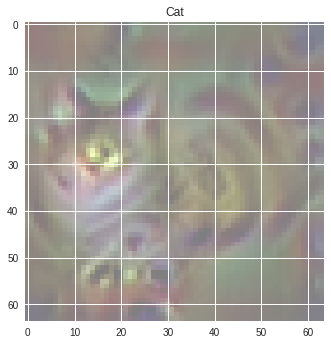

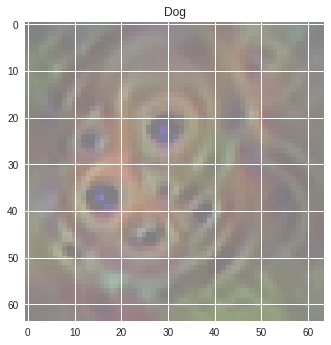

In [0]:
import numbers

# *********************
# class GaussianSmoothing
# TAKEN FROM https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/7
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))
        kernel = torch.Tensor(kernel).to(device)

        self.register_buffer('weight', kernel)
        self.groups = channels

        self.conv = F.conv2d

    def forward(self, img):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(img, weight=self.weight, groups=self.groups)



smoothing = GaussianSmoothing(3, 5, 1)
n_classes = 2
y = (torch.LongTensor(1,1).to(device)).random_() % n_classes
y_onehot = torch.FloatTensor(1, n_classes).to(device)

def gradient_ascent(model, img, n_times, label):
    
    model.eval()
    step_size = 3
           
    if label == 'Cat':
        y[0] = 0       
    else:
        y[0] = 1
    
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1) 
    
    for i in range(n_times):
      
      if i % 50 == 0:
        step_size /= 2

      if i % 4 == 0 and i > 0:
        # Gaussian blur
        img = F.pad(img, (2, 2, 2, 2), mode='reflect')
        img = smoothing(img)
      
      
      model.zero_grad()
          
      output = model(img)
      
      # with L2 regularization
      loss = output[0, y[0]] - 0.0001 * img.data.norm()
      
      if i % 20 == 0:
        print('%s : loss = %.4f' % (label, loss))
      grad = torch.autograd.grad(loss, img, 
                                 grad_outputs=y_onehot)
                 
      grad = grad[0].data
      img += step_size * grad 
      img = torch.clamp(img, 0., 1.)

      
    img = torch.clamp(img, 0., 1.)
    return img


model_vis = VGGNet().to(device)
# Load your trained model here
model_vis.load_state_dict(torch.load(added_path + 'model_89_vgg_net_3fc.pth'))
model_vis.eval()   

n_iter = 100
    
fake_img_size = [64, 64]

# Find the image that maximizes the score of the cat class
img_cat = torch.zeros(1, 3, fake_img_size[0], fake_img_size[1], 
                      requires_grad=True).to(device)

img_cat = gradient_ascent(model_vis, img_cat, n_iter, 'Cat')

torchvision.utils.save_image(img_cat , added_path + 'img_cat.png')
img_to_show = img_cat.view(3, fake_img_size[0], fake_img_size[1]).detach().cpu()
print_one_image(img_to_show, 'Cat')

# Find the image that maximizes the score of the dog
img_dog = torch.zeros(1, 3, fake_img_size[0], fake_img_size[1], 
                      requires_grad=True).to(device)   


img_dog = gradient_ascent(model_vis, img_dog, n_iter, 'Dog')
torchvision.utils.save_image(img_dog , added_path + 'img_dog.png')
img_to_show_dog = img_dog.view(3, fake_img_size[0], fake_img_size[1]).detach().cpu()
print_one_image(img_to_show_dog, 'Dog')




Visualize which images the neural network is incertain about 
(here images where the network
gives a probability between 48 and 52% for one class)

prob_cat = 50.28%
prob_cat = 48.41%
prob_cat = 48.06%
prob_cat = 51.24%
prob_cat = 48.40%
prob_cat = 49.09%
prob_cat = 51.33%
prob_cat = 49.24%
Accuracy of   Cat : 90 % (total = 1017)
Accuracy of   Dog : 97 % (total = 983)
Avg_Accuracy = 93 % 


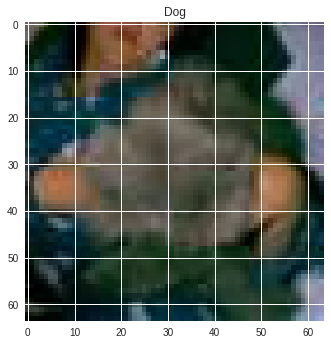

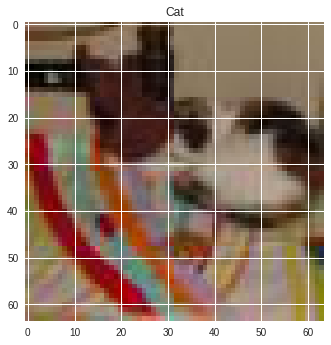

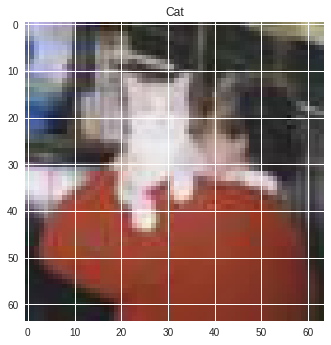

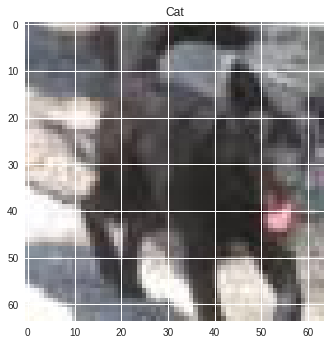

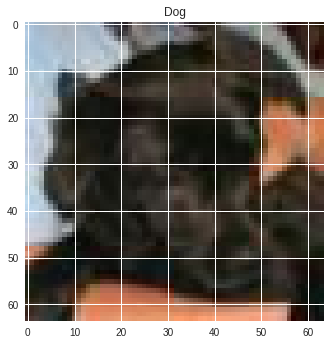

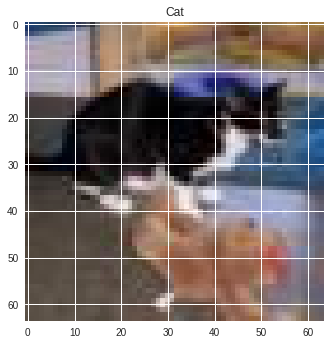

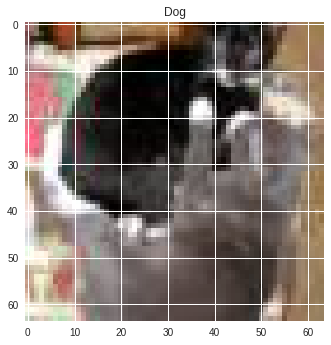

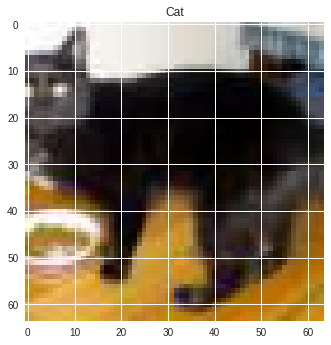

In [0]:
class_correct = torch.Tensor([0, 0])
class_total = torch.Tensor([0, 0])

img_size = 64
softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for ((inputs, target), img_path) in valid_loader:
        
        inputs, target = inputs.to(device), target.to(device)
        output = model_vis(inputs)
        prob_output = softmax(output)
        _, pred = torch.max(output, 1)
        
        c = (pred == target).squeeze()
        
        for i in range(len(inputs)):
            p1 = prob_output[i, 0].item()
            if 0.48 < p1 < 0.52:
              print('prob_cat = %.2f%%' % (p1*100))
              print_one_image(inputs[i].view(n_channels, img_size, img_size).cpu(), set_classes[c[i].item()])
              img = inputs[i] / 2 + 0.5  # unnormalize
              torchvision.utils.save_image(img, added_path + 'img_pred_prob_cat=' + str(round(p1*100, 2)) + '.png')
              
            label = target[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(num_classes):
    print('Accuracy of %5s : %2d %% (total = %d)' % (
        set_classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))
    
print('Avg_Accuracy = %2d %% ' % (100*(class_correct[0] + class_correct[1]) / (class_total[0] + class_total[1])))